In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib
import os


In [38]:
data = pd.read_csv("/Users/navtejkumarsingh/Downloads/Predicting-Credit-Risk-for-Loan-Applicants-main/data/german_credit_data.csv")
data.drop(columns=['Unnamed: 0'], inplace=True)  # Remove ID column
print(data.info())
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB
None


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [39]:
data['Saving accounts'].fillna(data['Saving accounts'].mode()[0], inplace=True)
data['Checking account'].fillna(data['Checking account'].mode()[0], inplace=True)


/var/folders/04/rstl77wx609gfy75bhwzv8400000gn/T/ipykernel_3946/3055458080.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Saving accounts'].fillna(data['Saving accounts'].mode()[0], inplace=True)
/var/folders/04/rstl77wx609gfy75bhwzv8400000gn/T/ipykernel_3946/3055458080.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whi

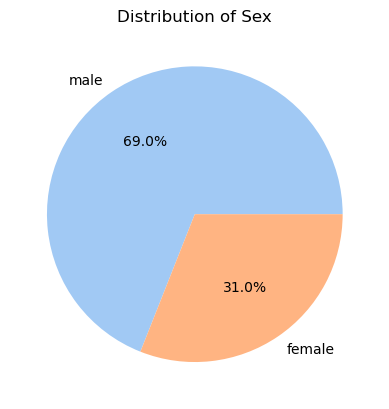

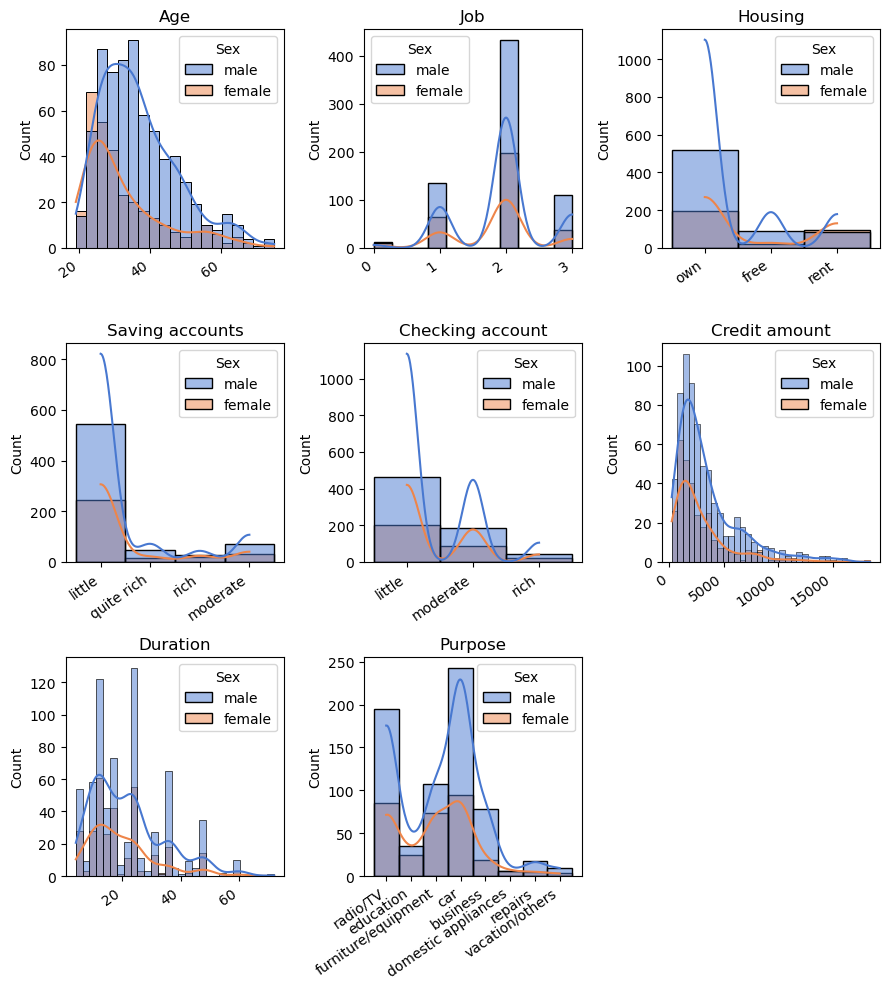

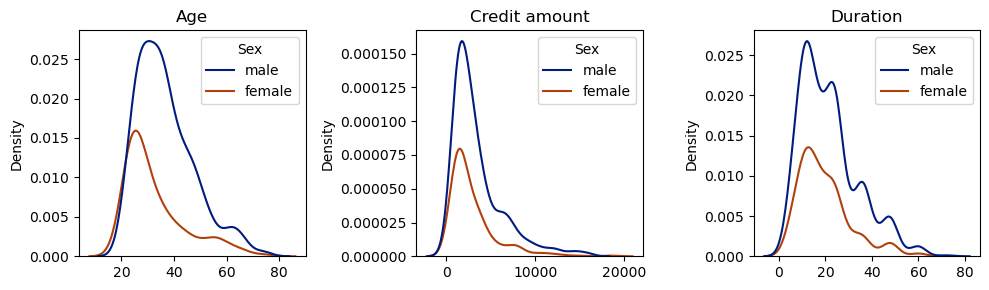

In [40]:
# Pie chart of Gender
plt.pie(data['Sex'].value_counts(),
        autopct='%1.1f%%',
        labels=data['Sex'].unique(),
        colors=sns.color_palette("pastel")[0:2])
plt.title('Distribution of Sex')
plt.show()

# Histograms of numerical features by Sex
plt.figure(figsize=(9, 10))
dist = data.drop('Sex', axis=1)

for i, col in enumerate(dist.columns):
    plt.subplot(3, 3, i+1)
    plt.title(col)
    sns.histplot(data=dist, x=col, hue=data['Sex'], kde=True, palette='muted')
    plt.xticks(rotation=35, ha='right')
    plt.xlabel('')

plt.tight_layout()
plt.show()

# KDE plots of key numerical features
plt.figure(figsize=(10, 3))
dist = data.drop(['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], axis=1)

for i, col in enumerate(dist.columns):
    plt.subplot(1, 3, i+1)
    plt.title(col)
    sns.kdeplot(data=dist, x=col, hue=data['Sex'], palette='dark')
    plt.xlabel('')

plt.tight_layout()
plt.show()


In [41]:
import numpy as np

# Randomly assign 'good' or 'bad' for demonstration
data['Risk'] = np.random.choice(['good', 'bad'], size=len(data))

# Then map it
data['Risk'] = data['Risk'].map({'good': 1, 'bad': 0})



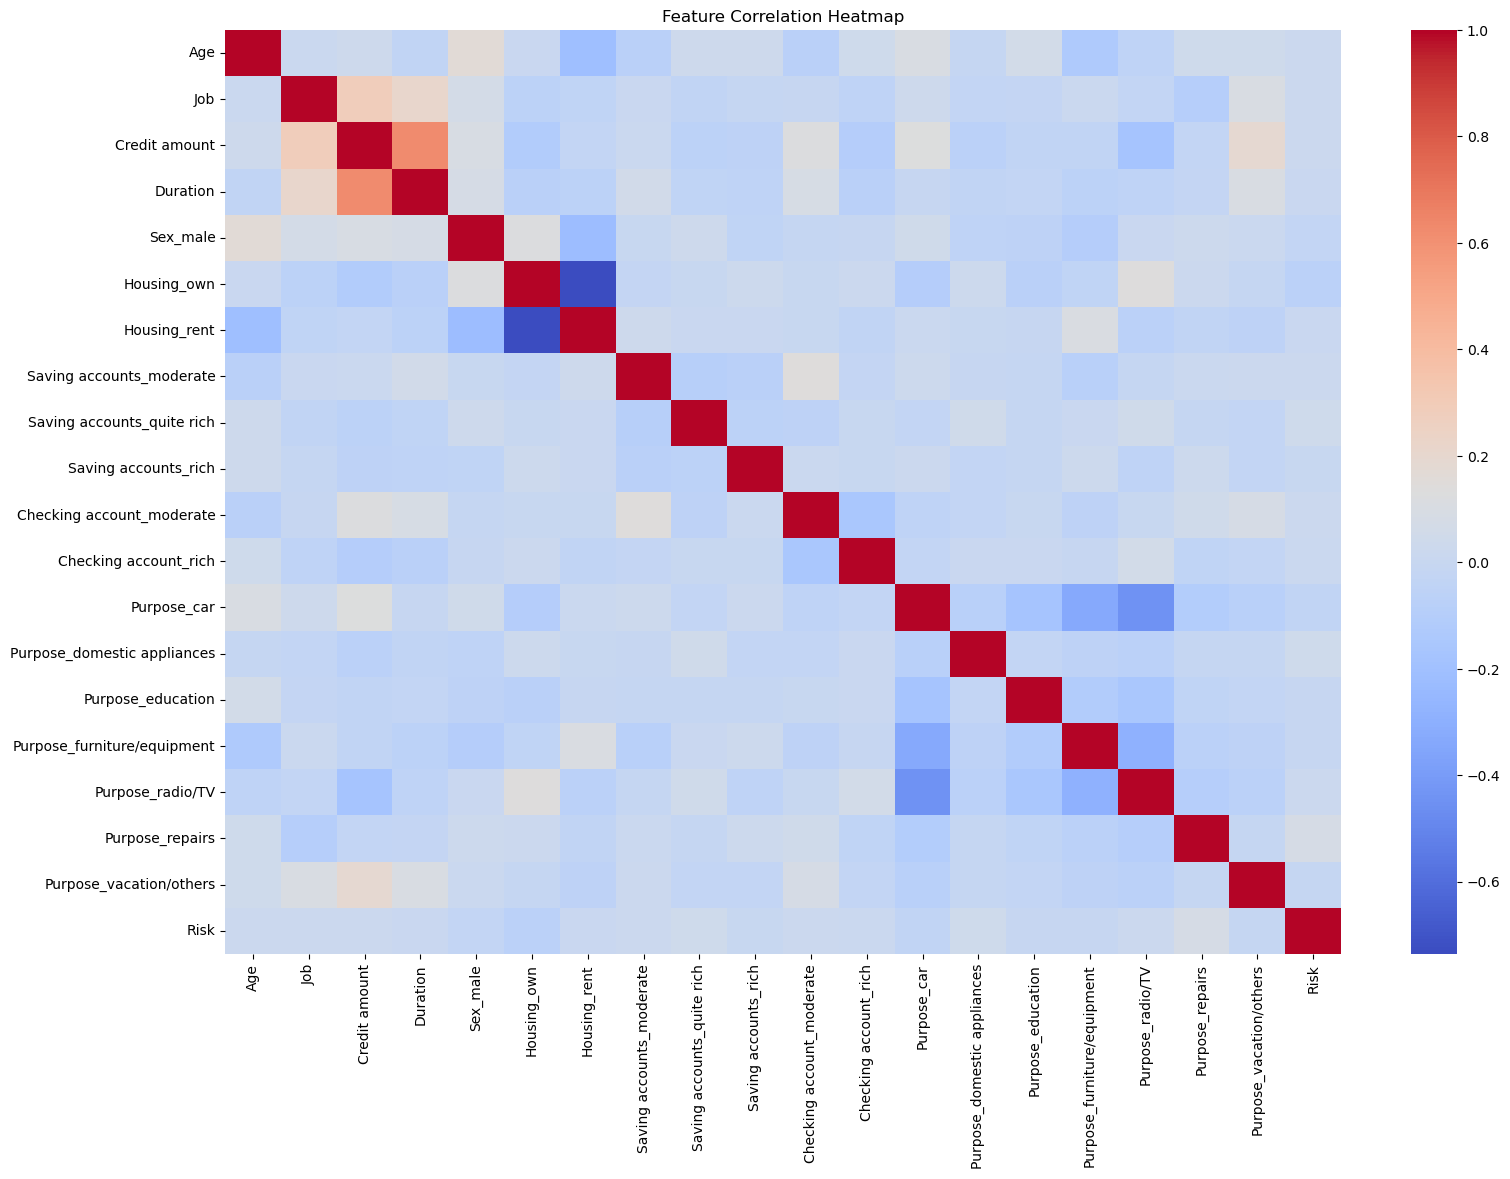

In [42]:
# Correlation heatmap
data_encoded = pd.get_dummies(data.drop('Risk', axis=1), drop_first=True)
data_encoded['Risk'] = data['Risk']

plt.figure(figsize=(18, 12))
sns.heatmap(data_encoded.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()


In [43]:
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
num_cols = ['Age', 'Job', 'Credit amount', 'Duration']

preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])


In [44]:
X = data.drop('Risk', axis=1)
y = data['Risk']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [45]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_prob is not None:
        print("AUC Score:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [46]:
log_reg_l1 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear'))
])
log_reg_l1.fit(X_train, y_train)
evaluate_model("Logistic Regression (L1)", log_reg_l1, X_test, y_test)



Logistic Regression (L1)
Accuracy: 0.5
Precision: 0.4883720930232558
Recall: 0.28378378378378377
F1 Score: 0.358974358974359
AUC Score: 0.5178698435277382
Confusion Matrix:
 [[108  44]
 [106  42]]


In [47]:
log_reg_l2 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='l2'))
])
log_reg_l2.fit(X_train, y_train)
evaluate_model("Logistic Regression (L2)", log_reg_l2, X_test, y_test)



Logistic Regression (L2)
Accuracy: 0.5
Precision: 0.4895833333333333
Recall: 0.31756756756756754
F1 Score: 0.38524590163934425
AUC Score: 0.5046230440967283
Confusion Matrix:
 [[103  49]
 [101  47]]


In [48]:
log_reg_none = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='none', solver='lbfgs', max_iter=200))
])
log_reg_none.fit(X_train, y_train)
evaluate_model("Logistic Regression (No Reg)", log_reg_none, X_test, y_test)



Logistic Regression (No Reg)
Accuracy: 0.49333333333333335
Precision: 0.4791666666666667
Recall: 0.3108108108108108
F1 Score: 0.3770491803278688
AUC Score: 0.49768847795163584
Confusion Matrix:
 [[102  50]
 [102  46]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [49]:
knn = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=32))
])
knn.fit(X_train, y_train)
evaluate_model("K-Nearest Neighbors (K=32)", knn, X_test, y_test)



K-Nearest Neighbors (K=32)
Accuracy: 0.5
Precision: 0.4888888888888889
Recall: 0.2972972972972973
F1 Score: 0.3697478991596639
AUC Score: 0.5304498577524894
Confusion Matrix:
 [[106  46]
 [104  44]]


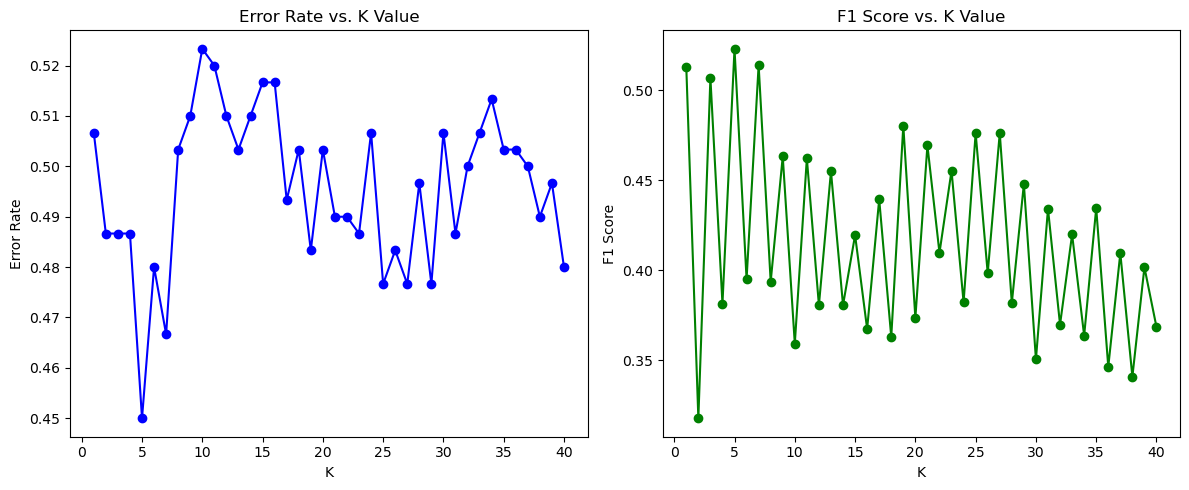

In [50]:
error_rate = []
f1_scores = []

for k in range(1, 41):
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', knn_temp)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    error_rate.append(np.mean(y_pred != y_test))
    f1_scores.append(f1_score(y_test, y_pred))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 41), error_rate, color='blue', marker='o')
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

plt.subplot(1, 2, 2)
plt.plot(range(1, 41), f1_scores, color='green', marker='o')
plt.title('F1 Score vs. K Value')
plt.xlabel('K')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()


In [51]:
rf = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])
rf.fit(X_train, y_train)
evaluate_model("Random Forest", rf, X_test, y_test)



Random Forest
Accuracy: 0.48333333333333334
Precision: 0.4748201438848921
Recall: 0.44594594594594594
F1 Score: 0.4599303135888501
AUC Score: 0.4902204836415363
Confusion Matrix:
 [[79 73]
 [82 66]]


In [52]:
gb = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=25, max_features=3, random_state=42))
])
gb.fit(X_train, y_train)
evaluate_model("Gradient Boosting", gb, X_test, y_test)



Gradient Boosting
Accuracy: 0.4766666666666667
Precision: 0.4536082474226804
Recall: 0.2972972972972973
F1 Score: 0.3591836734693878
AUC Score: 0.4558143669985775
Confusion Matrix:
 [[ 99  53]
 [104  44]]


In [53]:
stacking_model = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', StackingClassifier(
        estimators=[
            ('knn', KNeighborsClassifier(n_neighbors=32)),
            ('gb', GradientBoostingClassifier(n_estimators=25, max_features=3, random_state=42))
        ],
        final_estimator=LogisticRegression()
    ))
])
stacking_model.fit(X_train, y_train)
evaluate_model("Stacking (KNN + GB)", stacking_model, X_test, y_test)



Stacking (KNN + GB)
Accuracy: 0.52
Precision: 0.55
Recall: 0.14864864864864866
F1 Score: 0.23404255319148937
AUC Score: 0.5539206970128022
Confusion Matrix:
 [[134  18]
 [126  22]]


In [54]:
smote_pipe = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])
smote_pipe.fit(X_train, y_train)
evaluate_model("Logistic Regression (SMOTE)", smote_pipe, X_test, y_test)



Logistic Regression (SMOTE)
Accuracy: 0.49
Precision: 0.47572815533980584
Recall: 0.3310810810810811
F1 Score: 0.3904382470119522
AUC Score: 0.51800320056899
Confusion Matrix:
 [[98 54]
 [99 49]]



Model Comparison:

                 Model  Accuracy  Precision    Recall  F1 Score  AUC Score
6  Stacking (KNN + GB)  0.520000   0.550000  0.148649  0.234043   0.553921
1          LogReg (L1)  0.500000   0.488372  0.283784  0.358974   0.517870
2          LogReg (L2)  0.500000   0.489583  0.317568  0.385246   0.504623
3           KNN (K=32)  0.500000   0.488889  0.297297  0.369748   0.530450
0      LogReg (No Reg)  0.493333   0.479167  0.310811  0.377049   0.497688
7       LogReg (SMOTE)  0.490000   0.475728  0.331081  0.390438   0.518003
4        Random Forest  0.483333   0.474820  0.445946  0.459930   0.490220
5    Gradient Boosting  0.476667   0.453608  0.297297  0.359184   0.455814


/var/folders/04/rstl77wx609gfy75bhwzv8400000gn/T/ipykernel_3946/3239749345.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=results_df, palette="Blues_d")
/var/folders/04/rstl77wx609gfy75bhwzv8400000gn/T/ipykernel_3946/3239749345.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=results_df, palette="Greens_d")
/var/folders/04/rstl77wx609gfy75bhwzv8400000gn/T/ipykernel_3946/3239749345.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="AUC Score", y="Model", data=results_d

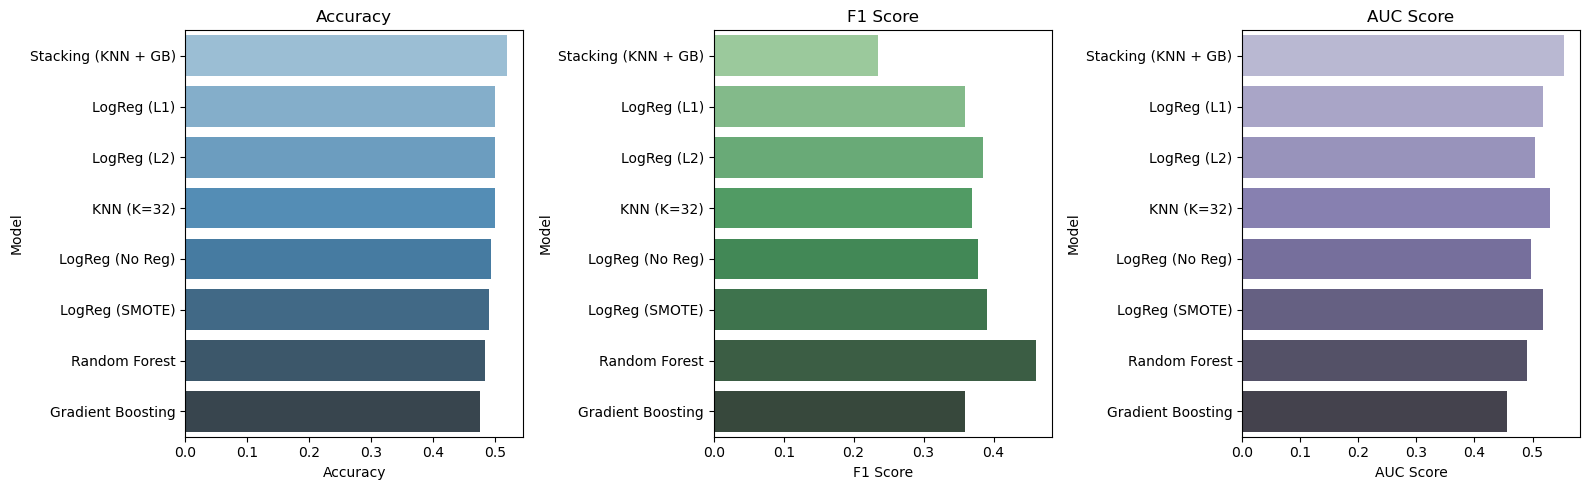

In [55]:
# Logging results
results = []

def log_results(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC Score": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    })

models = {
    "LogReg (No Reg)": log_reg_none,
    "LogReg (L1)": log_reg_l1,
    "LogReg (L2)": log_reg_l2,
    "KNN (K=32)": knn,
    "Random Forest": rf,
    "Gradient Boosting": gb,
    "Stacking (KNN + GB)": stacking_model,
    "LogReg (SMOTE)": smote_pipe
}

for name, model in models.items():
    log_results(name, model, X_test, y_test)

# Create DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
print("\nModel Comparison:\n")
print(results_df)

# Plotting
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="Blues_d")
plt.title("Accuracy")

plt.subplot(1, 3, 2)
sns.barplot(x="F1 Score", y="Model", data=results_df, palette="Greens_d")
plt.title("F1 Score")

plt.subplot(1, 3, 3)
sns.barplot(x="AUC Score", y="Model", data=results_df, palette="Purples_d")
plt.title("AUC Score")

plt.tight_layout()
plt.show()


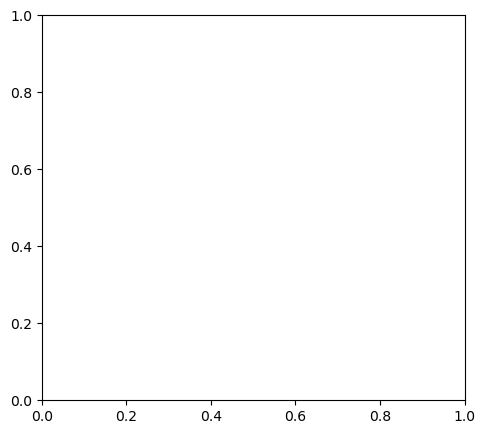

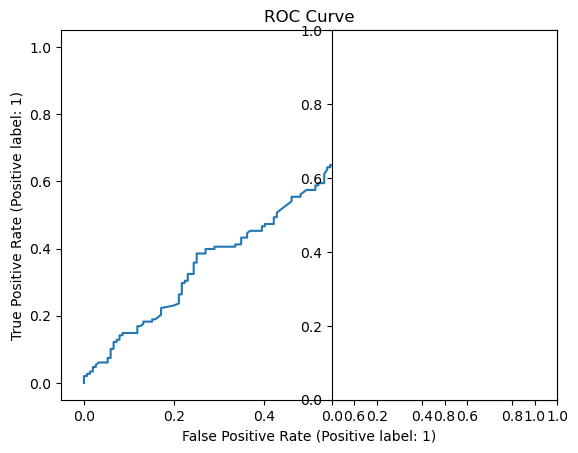

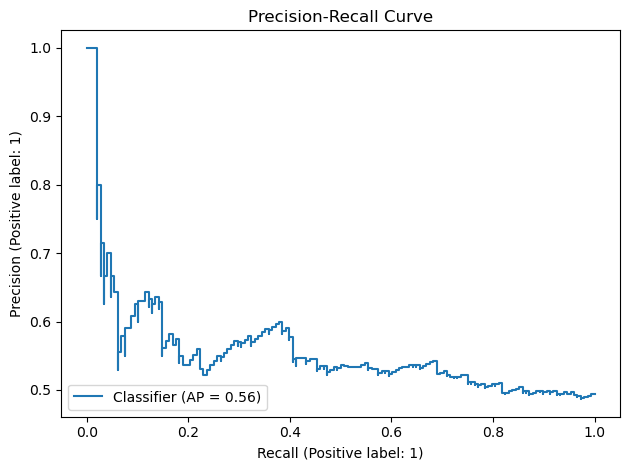

In [56]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Example for stacking_model
y_pred_proba = stacking_model.predict_proba(X_test)[:,1]

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


In [57]:
# Save best model
os.makedirs('model', exist_ok=True)
joblib.dump(stacking_model, 'model/best_model_stacking_knn_gb.pkl')


['model/best_model_stacking_knn_gb.pkl']